In [801]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
# These packages are required by the visualization utils
import seaborn as sns  
from sklearn.manifold import TSNE
import sklearn
from sklearn.preprocessing import Normalizer

In [802]:
import matplotlib.patches as patches

In [806]:
device = 'cuda'
# device = 'cpu'  # uncomment this line to run the model on the CPU
batch_size = 50

critical = np.array([[130, 70], [150, 50]])
train = np.load("/content/FireEvac_train_set.npy")
test = np.load("/content/FireEvac_test_set.npy")

#dat = np.vstack([train,critical])
#train_critic = (dat - dat.mean()) / dat.std()
#critical = train_critic[-2:, :]
#train = train_critic[:train.shape[0], :]
#test = (test - test.mean()) / test.std()
#print(critical)

# to normalize
train_critic = sklearn.preprocessing.normalize(np.vstack([train,critical]), axis=0, norm="max")
critical = train_critic[-2:, :]
print(critical)
train = train_critic[:train.shape[0], :]
test = sklearn.preprocessing.normalize(test, axis=0, norm="max")

train_np = torch.Tensor(train)

test_np = torch.Tensor(test)


train_dataset = torch.utils.data.TensorDataset(train_np)
test_dataset = torch.utils.data.TensorDataset(test_np)

if device == 'cuda':
  train_loader = torch.utils.data.DataLoader(
          train_dataset,
          batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
      )
  test_loader = torch.utils.data.DataLoader(
          test_dataset,
          batch_size=600, shuffle=True, num_workers=1, pin_memory=True
      )
  print("Loaded cuda")

[[0.68967964 0.64709498]
 [0.7957842  0.4622107 ]]
Loaded cuda


In [807]:
print(train_np)

tensor([[0.4599, 0.5772],
        [0.4008, 0.7225],
        [0.6549, 0.7898],
        ...,
        [0.2803, 0.4399],
        [0.0357, 0.4581],
        [0.1810, 0.4039]])


In [810]:
temp_data = train_loader.dataset[1][0]
#temp_data_class = train_loader.dataset[0][1]

print("First data sample in train data: ", temp_data)
#print("First data samples class: ", temp_data_class)

First data sample in train data:  tensor([0.4008, 0.7225])


In [811]:
def batch_diag(batched_variance):
    batch_shape = batched_variance.shape[:-1]
    event_size = batched_variance.size(-1)
    cov = batched_variance.new_zeros(batch_shape + (event_size * event_size,))
    cov[..., ::1 + event_size] = batched_variance
    return cov.reshape(batch_shape + (event_size, event_size))

In [812]:
class VAE(nn.Module):
  def __init__(self, batch_size, x_dim, latent_dim):
    super().__init__()
    self.x_dim = x_dim
    self.latent_dim = latent_dim
    self.batch_size = batch_size
    self.l_std = nn.Parameter(torch.ones(x_dim, requires_grad=True))
    

    self.encoder_1 = nn.Linear(x_dim, 256)

    self.encoder_2 = nn.Linear(256,256)

    self.encoder_mu = nn.Linear(256, latent_dim)
    self.encoder_sigma = nn.Linear(256, latent_dim)

    self.decoder_1 = nn.Linear(latent_dim,256)

    self.decoder_1_2 = nn.Linear(256,256)

    self.decoder_2 = nn.Linear(256,x_dim)
    self.decoder_3 = nn.Linear(256,x_dim) # turn this into a global parameter

  def encoder(self,x):
    x_relu = torch.relu(self.encoder_1(x))
    return self.encoder_mu(x_relu), self.encoder_sigma(x_relu)

  def latent_z_sampling(self, mu, logsigma):
    z = torch.empty_like(mu).normal_(0., 1.)
    return z* torch.exp(logsigma) + mu

  def KL_divergence(self, mu, logsigma):
    #In thesis the KL divergence for two normal distributions is given as:
    # 1/2 (sum over L(sigma**2 + mu**2 - log(sigma**2)-1))
    return 0.5 * (torch.exp(logsigma * 2) + torch.pow(mu, 2) - 2*logsigma -1).sum(-1)
    

  def decoder(self, z):
    z_relu = torch.relu(self.decoder_1(z))
    return torch.sigmoid(self.decoder_2(z_relu))

  def ELBO(self,x):
    mu, logsigma = self.encoder(x)
    z = self.latent_z_sampling(mu, logsigma)
    
    kl_divergence = self.KL_divergence(mu, logsigma)
    l_mean = self.decoder(z)
    
    cov_matrix = torch.diag(self.l_std.pow(2))
    
    #
    batched_cov_matrix = cov_matrix.repeat(x.shape[0], 1, 1)

    m = torch.distributions.MultivariateNormal(l_mean,batched_cov_matrix)

    neg_log_like = m.log_prob(x)  # should be a scalar

    return neg_log_like - kl_divergence

  def print_std(self):
    print(self.l_std)


  def reconstruced_images(self,x):
    mu, logsigma = self.encoder(x)
    z = self.latent_z_sampling(mu, logsigma)
    l_mean = self.decoder(z)
    
    l_log_sigma = self.l_std
    
    reconstructed = torch.normal(l_mean, l_log_sigma)
    return x, reconstructed

  def sample_new(self, sample_num):
    z = torch.empty(sample_num, self.latent_dim).normal_().to(device)
    likelihood_mean = self.decoder(z)
    l_log_sigma = self.l_std

    return torch.normal(likelihood_mean, l_log_sigma)




# Visualize samples Function:

In [813]:
def visualize_vae_samples(samples, num_rows=2, num_cols=5):
    """Plot random samples generated by the VAE.

    Args:
        samples: Samples drawn from the model, shape [num_samples, 28, 28]

    """
    sns.set_style('white')
    num_total = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
    for i in range(num_total):
        ax = axes[i // num_cols, i % num_cols]
        ax.scatter(samples[i][0], samples[i][1])
        #ax.imshow(samples[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(f'Sample #{i}')
    plt.tight_layout()
    plt.show()

# Visualize Embeddings Function:
We used the t-sne representation. https://distill.pub/2016/misread-tsne/ gives a good outlook on the tsne. The transformation is non-linear and adapts to data, therefore performs different transformations on different parts of data.
In sklearn documentation https://scikit-learn.org/0.15/modules/generated/sklearn.manifold.TSNE.html , it is said that pca is more stable than random init.

In [814]:
def visualize_embeddings(vae, x, y):
    sns.set_style('whitegrid')
    tsne = TSNE(perplexity=50.0, init='pca')
    # Obtain embeddings using VAE
    # The first output was mean, second one was log sigma
    means = vae.encoder(x)[0].cpu().detach().numpy()
    # Dimensionality reduction on the embeddings using t-SNE
    emb = tsne.fit_transform(means)

    plt.figure(figsize=[10, 7])
    labels = y.cpu().numpy()
    for l in np.unique(labels):
        class_ind = (labels == l)
        plt.scatter(emb[class_ind, 0], emb[class_ind, 1], label=f'{l}', alpha=0.5)
        plt.legend()
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

# New sample Visualization Wrapper Function:

In [815]:
def new_sample_wrapper(vae):
  x = vae.sample_new(15).view(-1, 2).detach().cpu().numpy()
  visualize_vae_samples(x,3,5)

# Reconstructed sample Visualization Wrapper Function:

In [867]:
def sample_vis_wrapper(vae, test_loader, sample_number = 15):
  max_epochs = 1
  #sample_number = 15
  for epoch in range(max_epochs):
      print(f'Epoch {epoch}')
      for ix, batch in enumerate(test_loader):
          x = batch[0]
          #print(x.shape)
          x = x.view(x.shape[0], x_dim).to(device)  # we flatten the image into 1D array
          # We want to maximize the ELBO, so we minimize the negative ELBO
          old_x, reconst_x = vae.reconstruced_images(x)
          old_x_np = old_x.cpu().detach().numpy()
          reconst_x_np = reconst_x.cpu().detach().numpy()
          print("old x:", old_x_np)
          print("reconstructed x: ", reconst_x_np)
          reconst_faculty(old_x_np,reconst_x_np)
          break
        

In [894]:
def reconst_faculty(x,reconst_x_np):
  fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
  ax1.scatter(x[:,0], x[:,1], color = "dodgerblue", s=5, label="Test Data")
  ax1.legend()
  ax2.scatter(reconst_x_np[:,0],reconst_x_np[:,1], color = "firebrick", s=5, label="Reconstructed Data")
  ax2.legend()
  plt.tight_layout()
  plt.show()


# Embedding Visualization Wrapper Function:

In [818]:
def embedding_wrapper(vae, test_loader, obs_dim = 2):
  x = next(iter(test_loader))
  x = x[0]
  x = x.view(x.shape[0], obs_dim).to(device)
  plt.figure(figsize=[10, 7])
  visualize_embeddings(vae, x, y)

In [819]:
def loss_plot(loss_arr):
  plt.plot(loss_arr)
  plt.xlabel("Number of batch")
  plt.show("The loss value")

# The train function:

In [820]:
def old_train_func(vae, opt, train_loader, loss_arr, max_epochs = 50, display_step = 100):
  for epoch in range(max_epochs):
      print(f'Epoch {epoch}')
      for ix, batch in enumerate(train_loader):
          x, y = batch
          x = x.view(x.shape[0], x_dim).to(device)  # we flatten the image into 1D array
          
          # We want to maximize the ELBO, so we minimize the negative ELBO
          loss = -vae.ELBO(x).mean(-1)
          loss_arr = np.append(loss_arr, loss.item())
          loss.backward()
          opt.step()
          opt.zero_grad()
          if ix % display_step == 0:
              print(f'  loss = {loss.item():.2f}')
              #vae.print_std()
          
  #print(loss_arr)
  return loss_arr

In [821]:
def train_func(vae, opt, train_loader, loss_arr, max_epochs = 50, display_step = 100):
  for epoch in range(max_epochs):
      print(f'Epoch {epoch}')
      for ix, batch in enumerate(train_loader):
          x = batch[0].to("cuda")
          
          # We want to maximize the ELBO, so we minimize the negative ELBO
          loss = -vae.ELBO(x).mean(-1)
          #print("in batch loss:", loss.item())
          loss_arr = np.append(loss_arr, loss.item())
          loss.backward()
          opt.step()
          opt.zero_grad()
          if ix % display_step == 0:
              print(f'  loss = {loss.item():.2f}')
          
  return loss_arr

# Create the model with desired parameters:

In [822]:
x_dim = 2
latent_dim = 5
vae = VAE(batch_size, x_dim, latent_dim).to(device)

for name, param in vae.named_parameters():
  if param.device.type != 'cuda':
    print('param {}, not on GPU'.format(name))  

opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

loss_arr = np.empty(0)

# Train the model:

First epoch results:

Epoch 0
  loss = -2.06
Epoch 1
  loss = -1.73
Epoch 2
  loss = -1.13
Epoch 3
  loss = -1.19
Epoch 4
  loss = -1.38
Epoch 5
  loss = -1.48
Epoch 6
  loss = -1.24
Epoch 7
  loss = -1.20
Epoch 8
  loss = -1.38
Epoch 9
  loss = -1.49
Epoch 10
  loss = -1.16
Epoch 11
  loss = -0.78
Epoch 12
  loss = -1.62
Epoch 13
  loss = -1.04
Epoch 14
  loss = -1.64
Epoch 15
  loss = -1.17
Epoch 16
  loss = -1.21
Epoch 17
  loss = -1.25
Epoch 18
  loss = -1.25
Epoch 19
  loss = -1.64
Epoch 20
  loss = -1.64
Epoch 21
  loss = -0.40
Epoch 22
  loss = -1.60
Epoch 23
  loss = -1.31
Epoch 24
  loss = -1.16
Epoch 25
  loss = -1.25
Epoch 26
  loss = -1.57
Epoch 27
  loss = -1.32
Epoch 28
  loss = -1.28
Epoch 29
  loss = -0.99
Epoch 30
  loss = -1.35
Epoch 31
  loss = -1.91
Epoch 32
  loss = -1.55
Epoch 33
  loss = -1.31
Epoch 34
  loss = -0.99
Epoch 35
  loss = -1.07
Epoch 36
  loss = -1.43
Epoch 37
  loss = -1.32
Epoch 38
  loss = -1.24
Epoch 39
  loss = -1.58
Epoch 40
  loss = -1.39
Epoch 41
  loss = -1.34
Ep

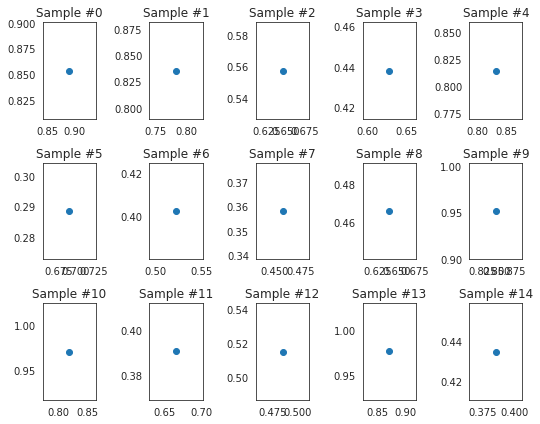

In [893]:
loss_arr = train_func(vae, opt, train_loader, loss_arr, 3000)
print("The 15 samples generated: ")
new_sample_wrapper(vae)


The 15 samples reconstructed: 
Epoch 0
old x: [[0.6848718  0.42780122]
 [0.4799235  0.17449145]
 [0.5379025  0.46754432]
 ...
 [0.6654756  0.46894592]
 [0.5275875  0.8029183 ]
 [0.18680541 0.54559696]]
reconstructed x:  [[0.6732544  0.44525936]
 [0.5389062  0.18933922]
 [0.544835   0.4267558 ]
 ...
 [0.6956268  0.49169034]
 [0.50879467 0.8158206 ]
 [0.16325185 0.54274887]]


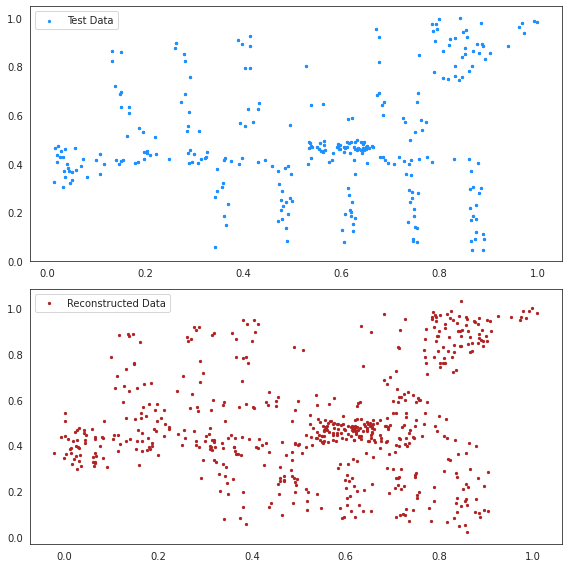

The Loss curve:


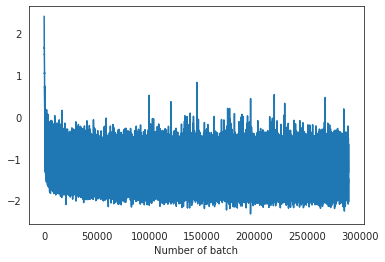

In [895]:
print("The 15 samples reconstructed: ")
sample_vis_wrapper(vae, test_loader)
print("The Loss curve:")
loss_plot(loss_arr)

In [896]:
def sample_generator(vae, sample_num):
  for ix, batch in enumerate(test_loader):
          x = batch[0]
          x = x.view(x.shape[0], x_dim).to(device)
          x = x.cpu().detach().numpy()  # we flatten the image into 1D array
          new_x = vae.sample_new(sample_num).view(-1, 2).detach().cpu().numpy()       
          fig, ax = plt.subplots(1,1, figsize=(12, 8))
          ax.scatter(x[:,0], x[:,1], color='dodgerblue', s=5, label="Test data")
          ax.scatter(new_x[:,0], new_x[:,1],  color='darkred', s=10, label="Generated data")
          ax.legend()
          plt.show()
          break

def critical_number(vae,critical):
  x_list = []
  critical_list = []
  critical_point_num = 0
  while critical_point_num < 100:
    x = vae.sample_new(1).view(-1, 2).detach().cpu().numpy()
    if  critical[0][0]<= x[0][0] <= critical[1][0] and critical[1][1] <= x[0][1] <= critical[0][1]:
      critical_point_num += 1
      critical_list.append(x[0])
    else:
      x_list.append(x[0])
  x_list = np.array(x_list)
  critical_list = np.array(critical_list)
  return x_list, critical_list

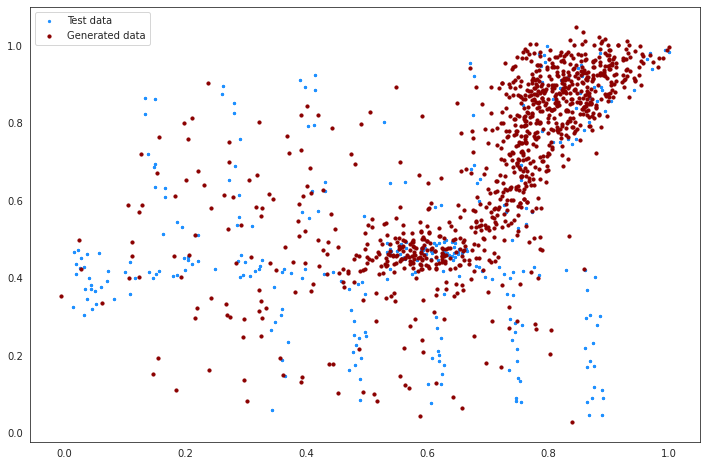

In [899]:
sample_generator(vae, 1000)

[[0.81741935 0.8441135 ]
 [0.52925557 0.531056  ]
 [0.6486307  0.3907357 ]
 ...
 [0.12473597 0.28732893]
 [0.78467697 0.90597063]
 [0.60027057 0.3379836 ]]
(985, 2)
(100, 2)


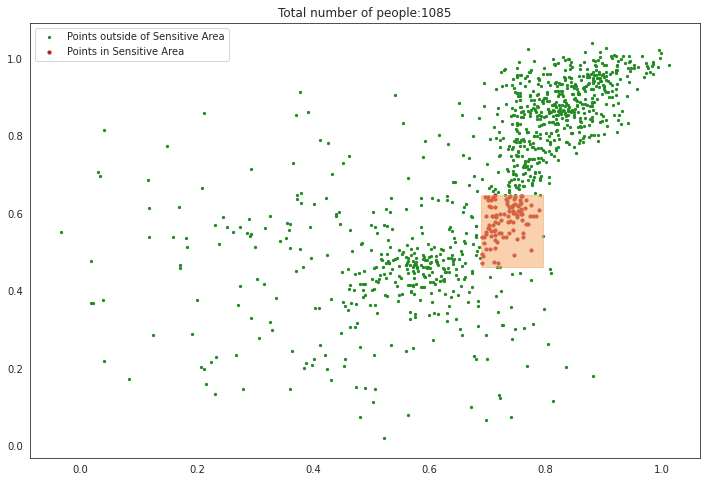

In [906]:
x_list, critical_list = critical_number(vae,critical)
print(x_list)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(x_list[:, 0], x_list[:, 1], color='forestgreen', s=5, label="Points outside of Sensitive Area")
ax.scatter(critical_list[:, 0], critical_list[:, 1], color='firebrick', s=10, label="Points in Sensitive Area")
ax.set_title("Total number of people:{}".format(x_list.shape[0] + critical_list.shape[0]))
ax.legend()
restricted_area = patches.Rectangle((0.68967964, 0.64709498), 0.7957842 - 0.68967964 , 0.4622107 - 0.64709498, linewidth=1,alpha=0.5, edgecolor='sandybrown',facecolor='sandybrown')
ax.add_patch(restricted_area)
print(x_list.shape)
print(critical_list.shape)